In [1]:
from sklearn.model_selection import train_test_split,cross_val_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
import string
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
import contractions
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel,BertTokenizer,get_linear_schedule_with_warmup
import numpy as np
from textwrap import wrap

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")





data = pd.read_csv("communications.csv",delimiter=',')
data.head(10)

cpu


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Date,Release Date,Type,Text
0,2025-03-19,2025-04-09,Minute,Minutes of the Federal Open Market Committee\n...
1,2025-03-19,2025-03-19,Statement,Recent indicators suggest that economic activi...
2,2025-01-29,2025-01-29,Statement,Recent indicators suggest that economic activi...
3,2025-01-29,2025-02-19,Minute,Minutes of the Federal Open Market Committee\n...
4,2024-12-18,2024-12-18,Statement,Recent indicators suggest that economic activi...
5,2024-12-18,2025-01-08,Minute,Minutes of the Federal Open Market Committee\n...
6,2024-11-07,2024-11-26,Minute,Minutes of the Federal Open Market Committee\n...
7,2024-11-07,2024-11-07,Statement,Recent indicators suggest that economic activi...
8,2024-09-18,2024-09-18,Statement,Recent indicators suggest that economic activi...
9,2024-09-18,2024-10-09,Minute,Minutes of the Federal Open Market Committee\n...


In [2]:
"""A seperate DataFrame for traditional ML models"""

df =  data.copy()
df['Text'].head(10)


0    Minutes of the Federal Open Market Committee\n...
1    Recent indicators suggest that economic activi...
2    Recent indicators suggest that economic activi...
3    Minutes of the Federal Open Market Committee\n...
4    Recent indicators suggest that economic activi...
5    Minutes of the Federal Open Market Committee\n...
6    Minutes of the Federal Open Market Committee\n...
7    Recent indicators suggest that economic activi...
8    Recent indicators suggest that economic activi...
9    Minutes of the Federal Open Market Committee\n...
Name: Text, dtype: object

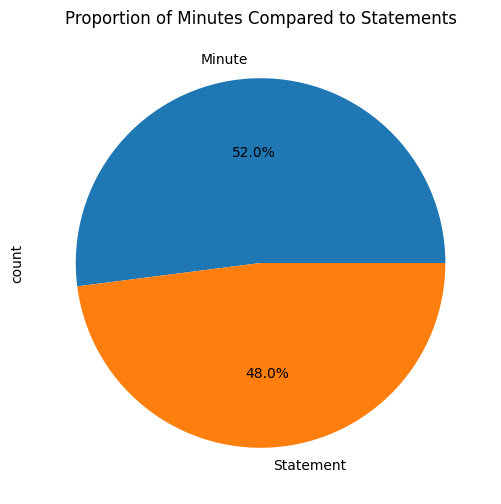

In [3]:
df.drop('Release Date',axis=1,inplace=True)


plt.figure(figsize=(10,6))
df['Type'].value_counts().plot(kind='pie',autopct="%1.1f%%")
plt.title("Proportion of Minutes Compared to Statements")
plt.show()

In [4]:
"""User defined function the standardize text data"""


def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>','',text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text =contractions.fix(text)
    text = re.sub(r'd\+','',text)
    text = re.sub(r'[^A-Za-z0-9\s]','',text)
    text = contractions.fix(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    STOPWORDS = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in STOPWORDS]
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(token) for token in tokens]
    text = " ".join(tokens)
    return text
    
df['clean_text'] = df['Text'].apply(clean_text)
df['clean_text'].head()

0    minute federal open market committee march 181...
1    recent indicator suggest economic activity con...
2    recent indicator suggest economic activity con...
3    minute federal open market committee january 2...
4    recent indicator suggest economic activity con...
Name: clean_text, dtype: object

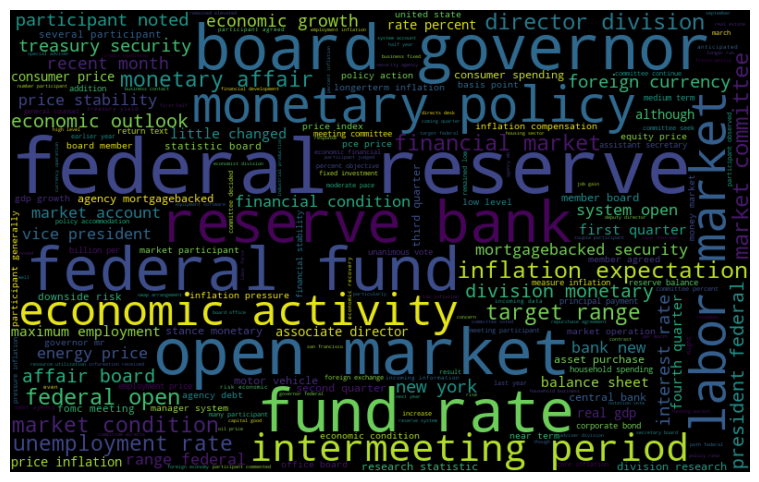

In [5]:
""" WordCloud to display word frequencies"""
sample = " ".join(i for i in df['clean_text'].astype(str))

plt.figure(figsize=(10,6))
wc = WordCloud(height=500,width=800).generate(sample)
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.savefig("images/wordcloud")
plt.show()


In [6]:


"""Most Common Words and Misc NLP Tasks"""


most_common = nltk.FreqDist(TextBlob(sample).words).most_common(100)
print(f'Top 100 Most Common Words: {most_common}')

Top 100 Most Common Words: [('market', 14828), ('committee', 14155), ('rate', 12739), ('inflation', 12674), ('federal', 11907), ('economic', 9929), ('participant', 9343), ('price', 8651), ('policy', 8506), ('reserve', 7049), ('bank', 6935), ('board', 6835), ('would', 6692), ('growth', 6011), ('condition', 5764), ('financial', 5757), ('monetary', 5753), ('remained', 5121), ('continued', 5089), ('percent', 4974), ('meeting', 4952), ('period', 4871), ('quarter', 4816), ('security', 4805), ('year', 4711), ('recent', 4654), ('labor', 4605), ('level', 4445), ('fund', 4381), ('member', 4290), ('increase', 4202), ('business', 4188), ('open', 4173), ('risk', 4149), ('governor', 3986), ('activity', 3923), ('consumer', 3891), ('foreign', 3856), ('month', 3839), ('outlook', 3822), ('pace', 3773), ('also', 3592), ('division', 3521), ('spending', 3329), ('expected', 3239), ('economy', 3151), ('system', 3125), ('expectation', 3105), ('likely', 3080), ('treasury', 3079), ('credit', 3055), ('noted', 30

In [7]:



blob = TextBlob(sample[:1000])
"""Parts of Speech Tagging"""
pos_tags = []
for pos in blob.pos_tags:
    pos_tags.append(pos)

print(pos_tags)

[('minute', 'JJ'), ('federal', 'JJ'), ('open', 'JJ'), ('market', 'NN'), ('committee', 'NN'), ('march', 'NN'), ('1819', 'CD'), ('2025', 'CD'), ('joint', 'JJ'), ('meeting', 'VBG'), ('federal', 'JJ'), ('open', 'JJ'), ('market', 'NN'), ('committee', 'NN'), ('board', 'NN'), ('governor', 'VBZ'), ('federal', 'JJ'), ('reserve', 'NN'), ('system', 'NN'), ('held', 'VBD'), ('office', 'NN'), ('board', 'NN'), ('governor', 'NN'), ('tuesday', 'IN'), ('18', 'CD'), ('2025', 'CD'), ('900', 'CD'), ('continued', 'VBN'), ('wednesday', 'JJ'), ('march', 'NN'), ('19', 'CD'), ('2025', 'CD'), ('900', 'CD'), ('am1', 'JJ'), ('review', 'NN'), ('monetary', 'JJ'), ('policy', 'NN'), ('strategy', 'NN'), ('tool', 'NN'), ('communication', 'NN'), ('committee', 'NN'), ('participant', 'JJ'), ('continued', 'VBD'), ('discussion', 'NN'), ('related', 'VBN'), ('review', 'JJ'), ('federal', 'JJ'), ('reserve', 'NN'), ('monetary', 'JJ'), ('policy', 'NN'), ('framework', 'NN'), ('focus', 'NN'), ('labor', 'NN'), ('market', 'NN'), ('dyn

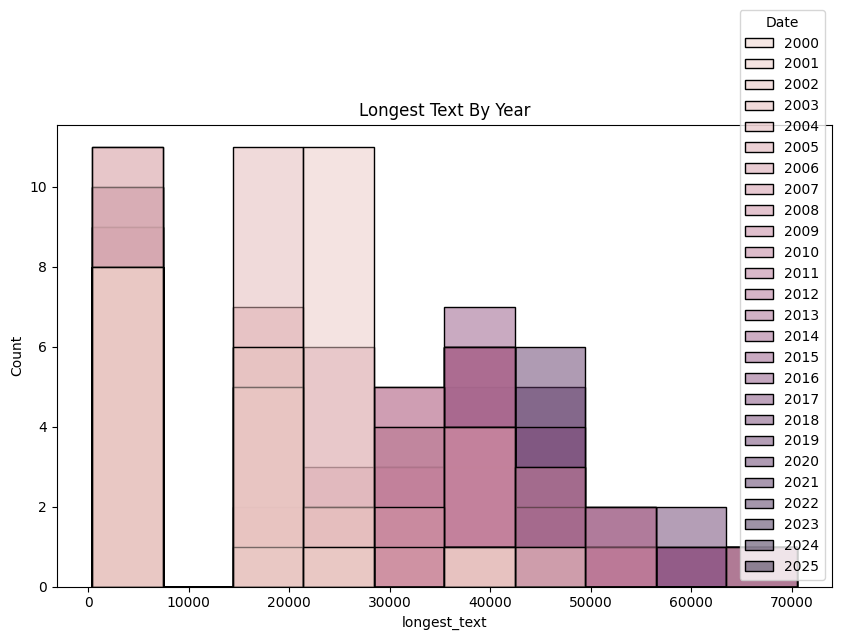

In [8]:


""" Copying df for datetime"""


df1 = df.copy()
df1['Date'] = pd.to_datetime(df1['Date'])
df1 = df1.set_index('Date')
df1 = df1.sort_index()






df1['longest_text'] = df1['clean_text'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(x=df1['longest_text'],hue=df1.index.year)
plt.title("Longest Text By Year")
plt.savefig("images/longest.png")
plt.show()

                   Model  Accuracy Score  F1 Score  Cross Validation Scores
0     logisticregression        1.000000  1.000000                 1.000000
1  multinomialnaivebayes        0.988889  0.986667                 0.979447
2      benoulinaivebayes        1.000000  1.000000                 1.000000


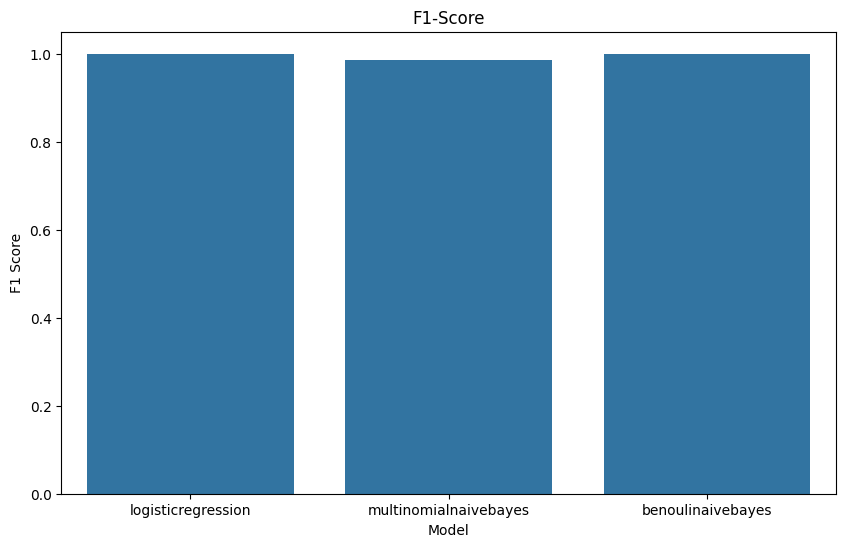

In [9]:

le = LabelEncoder()
tfid = TfidfVectorizer()


X = df['clean_text']
y = df['Type']
y = le.fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

X_train_tfid = tfid.fit_transform(X_train).toarray()
X_test_tfid = tfid.transform(X_test).toarray()



"""For the results of the models"""

models = {
    "logisticregression":LogisticRegression(),
    "multinomialnaivebayes":MultinomialNB(),
    "benoulinaivebayes":BernoulliNB()
    }



def evalaute(model_name,y_test,acc,f1,cv_scores):
    results = {
        "Model":model_name,
        "Accuracy Score":acc,
        "F1 Score":f1,
        "Cross Validation Scores":cv_scores.mean()
        }
    return results


dict_list = []


for model_name,model in models.items():
    model = model.fit(X_train_tfid,y_train)
    pred=  model.predict(X_test_tfid)
    acc = accuracy_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    cv_scores=  cross_val_score(model, X_train_tfid,y_train,cv=5,scoring="f1")
    dict_list.append(evalaute(model_name, y_test, acc, f1,cv_scores))

df_results = pd.DataFrame(dict_list)
print(df_results.head())
    
"""plotting the results from the models"""


plt.figure(figsize=(10,6))
sns.barplot(x=df_results['Model'],y=df_results['F1 Score'])
plt.title("F1-Score")
plt.savefig("images/results_f1_score.png")
plt.show()

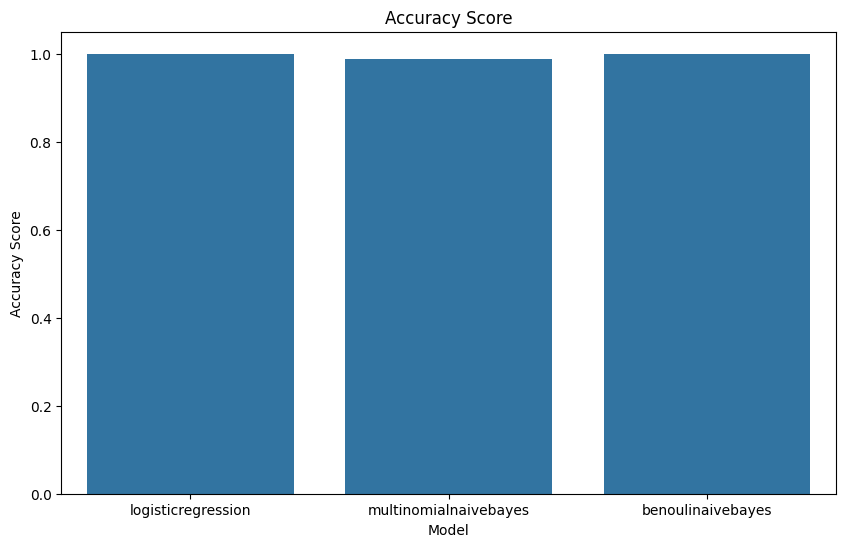

In [10]:

plt.figure(figsize=(10,6))
sns.barplot(x=df_results['Model'],y=df_results['Accuracy Score'])
plt.title("Accuracy Score")
plt.savefig("images/results_accuracy.png")
plt.show()



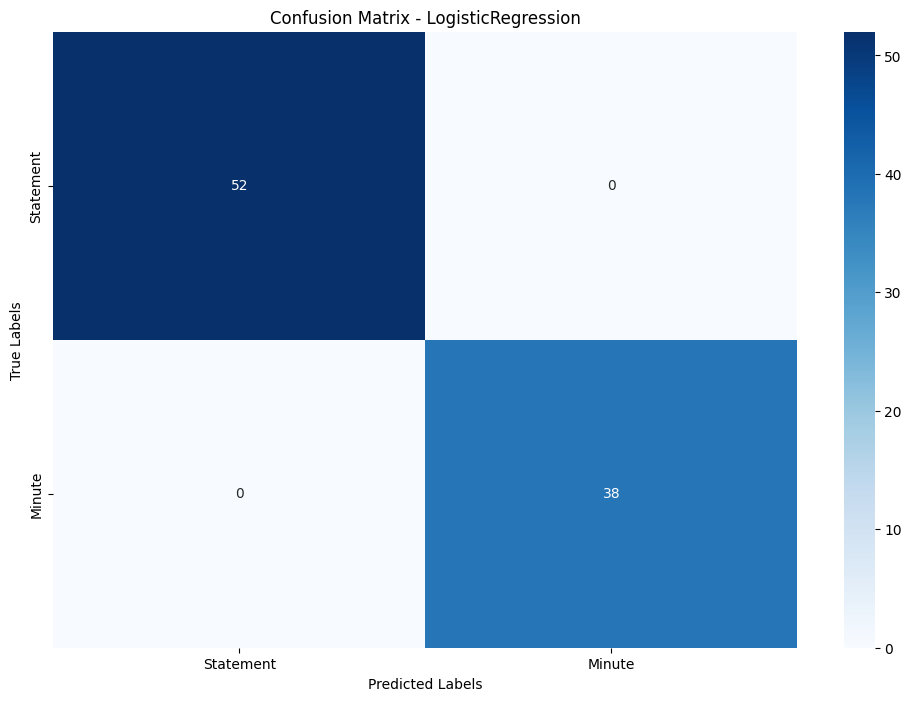

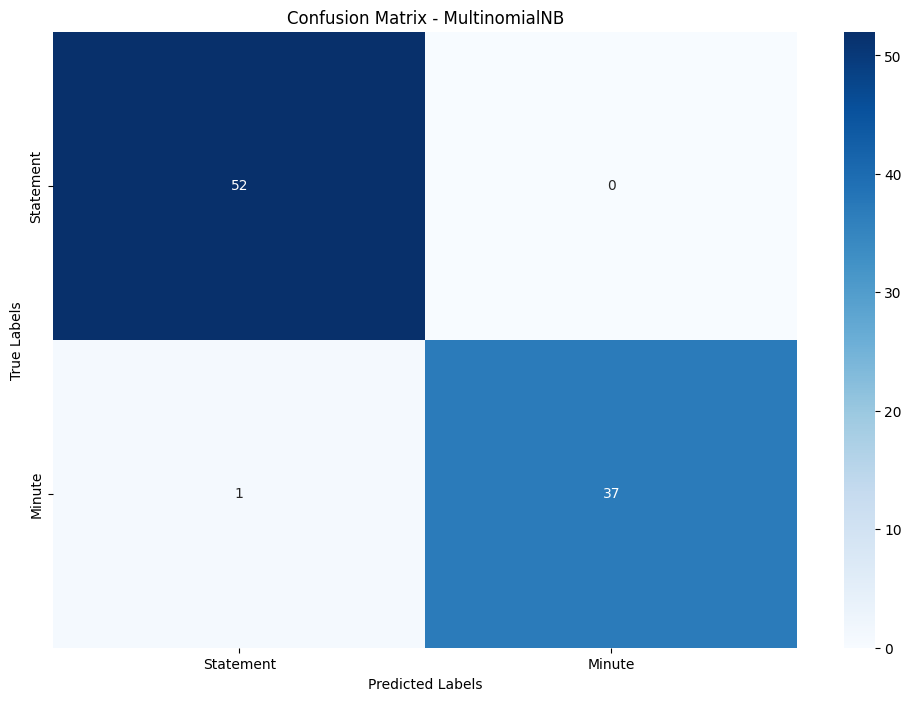

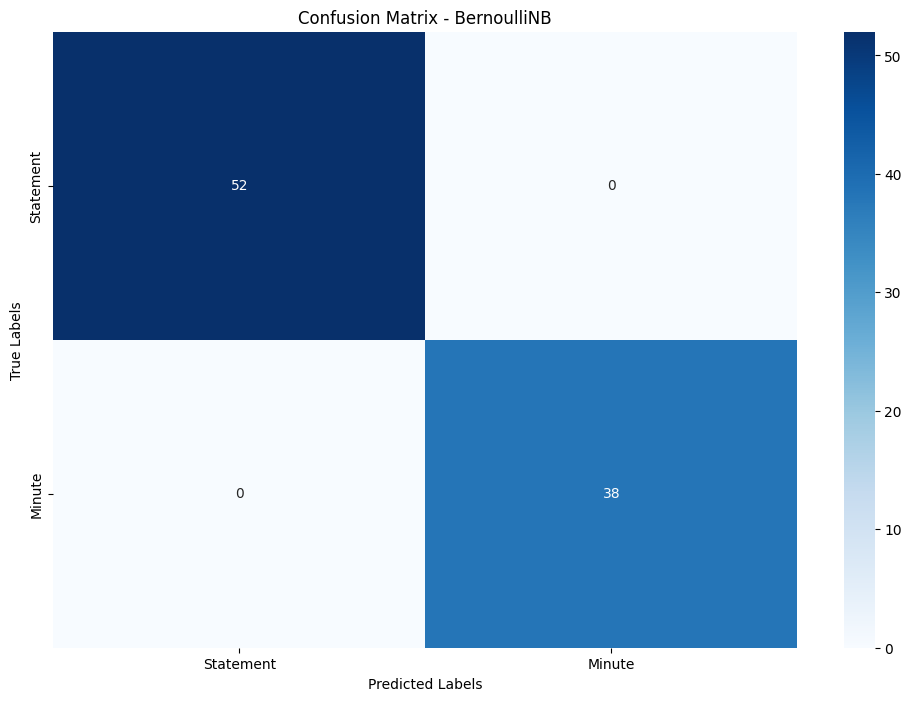

In [11]:
"""Confusion Matrix"""


def plot_confusion_matrix(y_test, y_pred, model):
    conmap = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,8))
    sns.heatmap(conmap, annot=True, fmt='d', cmap='Blues',xticklabels=["Statement","Minute"],yticklabels=["Statement","Minute"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()


for model_name, model in models.items():
    model = model.fit(X_train_tfid, y_train)
    y_pred = model.predict(X_test_tfid)
    plot_confusion_matrix(y_test, y_pred, model)

In [12]:
"""Now for fine-tuning bert using torch and Huggin Face"""



df_bert = data[['Text','Type']]
df_bert.drop_duplicates(inplace=True)

LABELS = ["Statement","Minute"]
df_bert['Type'] = df_bert['Type'].map({"Statement":0,"Minute":1})




MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)



MAX_LEN = 228

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self,Text,targets,max_len,tokenizer):
        self.Text = Text
        self.targets = targets
        self.max_len = max_len
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.Text)
    
    
    def __getitem__(self,index):
        Text = str(self.Text[index])
        target = self.targets[index]
        
        encoder = self.tokenizer.encode_plus(
            Text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors="pt"
            )
        
        return {
        "Text":Text,
        "input_ids":encoder['input_ids'].flatten(),
        "attention_mask":encoder['attention_mask'].flatten(),
        "targets":torch.tensor(target,dtype=torch.long)
        }



df_train,df_test = train_test_split(df_bert,test_size=.20,random_state=42)
df_val,df_test = train_test_split(df_test,test_size=.50,random_state=42)


BATCH_SIZE = 8
learning_rate = 2e-5

def get_dataloader(df,max_len,batch_size,tokenizer):
    ds = custom_dataset(
        Text = df['Text'].to_numpy(),
        targets = df['Type'].to_numpy(),
        max_len=max_len,
        tokenizer=tokenizer
        )
    return torch.utils.data.DataLoader(
        ds,
        num_workers=0,
        batch_size=batch_size
        )


train_dataloader = get_dataloader(df_train, MAX_LEN, BATCH_SIZE, tokenizer)
test_dataloader = get_dataloader(df_test, MAX_LEN, BATCH_SIZE, tokenizer)
val_dataloader = get_dataloader(df_val, MAX_LEN, BATCH_SIZE, tokenizer)





class Bert_Classifier(nn.Module):
    def __init__(self):
        super(Bert_Classifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(768,2)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)
    



model = Bert_Classifier()
model.to(device)

C:\Users\katsa\AppData\Local\Temp\ipykernel_4528\1348245635.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bert.drop_duplicates(inplace=True)
C:\Users\katsa\AppData\Local\Temp\ipykernel_4528\1348245635.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bert['Type'] = df_bert['Type'].map({"Statement":0,"Minute":1})


Bert_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [13]:


epochs = 4
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)




def training_epoch(model,dataloader,loss_fn,optimizer,device,scheduler,n_examples):
    model.train()
    losses = []
    predictions = 0
    for d in dataloader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(
            attention_mask=attention_mask,
            input_ids=input_ids
            )
        _,preds = torch.max(outputs,dim=1)
        loss = loss_fn(outputs,targets)
        predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return (predictions.double() / n_examples,np.mean(losses))



def eval_model(model,dataloader,loss_fn,device,n_examples):
    model.eval()
    losses = []
    predictions = 0
    
    
    with torch.no_grad():
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                attention_mask=attention_mask,
                input_ids=input_ids
                )
            
            _,preds = torch.max(outputs,dim=1)
            loss = loss_fn(outputs,targets)
            
            predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
        return (predictions.double() / n_examples,np.mean(losses))






for epoch in range(epochs):
    print(f'{epoch+1}/{epochs}')
    
    train_acc,train_loss = training_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
        )
    
    
    val_acc,val_loss = eval_model(model, val_dataloader, loss_fn, device, len(df_val))
    print(f" Training accuracy {train_acc*100:.2f}%; -Val Accuracy-- {val_acc*100:.2f}%")
    print(f"training loss {train_loss*100:.2f}%; --val loss-- {val_loss*100:.2f}%")




test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(df_test)
)

print(f'Testing Accuracy : {test_acc.item() *100 :.2f}%')

1/4
 Training accuracy 96.99%; -Val Accuracy-- 97.62%
training loss 18.26%; --val loss-- 7.85%
2/4
 Training accuracy 99.70%; -Val Accuracy-- 100.00%
training loss 1.64%; --val loss-- 0.22%
3/4
 Training accuracy 100.00%; -Val Accuracy-- 100.00%
training loss 0.23%; --val loss-- 0.14%
4/4
 Training accuracy 100.00%; -Val Accuracy-- 100.00%
training loss 0.18%; --val loss-- 0.12%
Testing Accuracy : 100.00%


In [25]:

def get_predictions(model, dataloader):
  model.eval()
  
  Texts = []
  pred = []
  real_values = []

  with torch.no_grad():
    for d in dataloader:

      Text = d["Text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)



      Texts.extend(Text)
      pred.extend(preds)
      real_values.extend(targets)

  pred = torch.stack(pred).cpu()
  real_values = torch.stack(real_values).cpu()
  return Texts, pred, real_values




y_Texts, y_pred, y_test = get_predictions(model, test_dataloader)


print(classification_report(y_pred,y_test,target_names=LABELS))

f1 = f1_score(y_pred,y_test,average="macro")
print(f'The weighted f1 score: {f1*100:.2f}%')

acc_score = accuracy_score(y_pred,y_test)
print(f'Accuracy Score: {acc_score*100:.2f}%')

              precision    recall  f1-score   support

   Statement       1.00      1.00      1.00        21
      Minute       1.00      1.00      1.00        21

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

The weighted f1 score: 100.00%
Accuracy Score: 100.00%


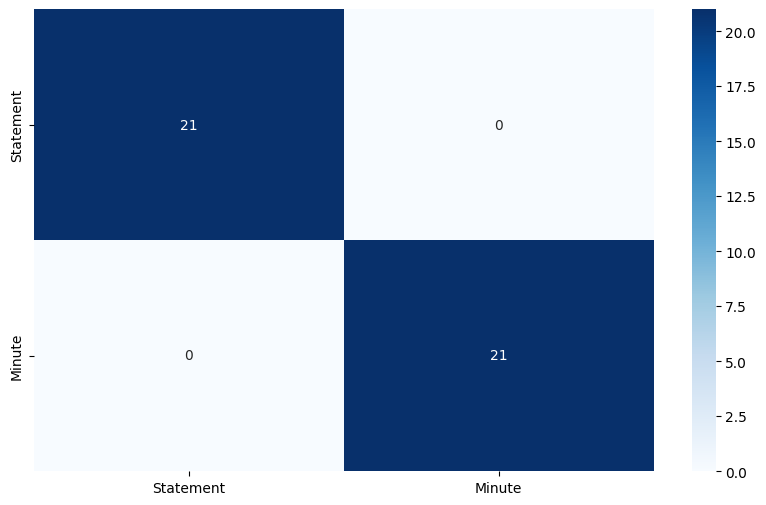

In [26]:
def plt_confusion_matrix(y_pred,y_test):
    cm = confusion_matrix(y_pred,target_values)
    sns.heatmap(cm, fmt='d',annot=True,cmap="Blues",xticklabels=LABELS,yticklabels=LABELS)


plt.figure(figsize=(10,6))
plt_confusion_matrix(y_pred, target_values)
plt.show()



In [27]:
idx = 2

Texts = y_Texts[idx]
true_text = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': LABELS,
  'values': y_pred[idx]
})

print("\n".join(wrap(Texts)))
print()
print(f'Minute or Statement: {LABELS[true_text]}')


Minutes of the Federal Open Market Committee   May 7, 2002      A
meeting of the Federal Open Market Committee was held in the offices
of the Board of Governors of the Federal Reserve System in Washington,
D.C., on Tuesday, May 7, 2002, at 9:00 a.m.
Present:Mr. Greenspan, Chairman Mr. McDonough, Vice Chairman Ms. Bies
Mr. Ferguson Mr. Gramlich  Mr. Jordan Mr. McTeer Mr. Olson Mr.
Santomero  Mr. SternMessrs. Broaddus, Guynn, Moskow, and Parry,
Alternate Members
of the Federal Open Market Committee  Mr. Hoenig, Ms. Minehan, and Mr.
Poole, Presidents of the Federal Reserve Banks of Kansas City, Boston,
and St. Louis respectively  Mr. Kohn, Secretary and Economist Mr.
Bernard, Deputy Secretary Mr. Gillum, Assistant Secretary Ms. Smith,
Assistant Secretary Mr. Mattingly, General Counsel Mr. Baxter, Deputy
General Counsel Ms. Johnson, Economist Mr. Reinhart, Economist Mr.
Stockton, Economist  Mr. Connors, Ms. Cumming, Messrs. Howard and
Lindsey,            Ms. Mester, Messrs. Oliner, Rolnick